# Migraines and Barometric Pressure Change
- The goal of this notebook is to understand how patients report migraines and if they are associated with pressure chanegs. 




In [126]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
from plot_functions.load_palette import load_palette
import data_processing.import_data as imp
import importlib
import plot_functions.format_axis as fmt
import data_processing.map_data_dict as map_data


In [129]:
importlib.reload(imp)
longitudinal_data = imp.import_all_longitudinal_files(clean_only=True, add_demog=True)
palette = load_palette()
longitudinal_data

IMPORTING LONGITUDINAL DATA FROM:
	/Users/akre96/Data/DGC_Study/Longitudinal Data with New Barometric Data
	Only importing patients with demographic information, and data until end of study
	Removed 0 subjects 33 remain
	Adding Demographic information to longitudinal data


,subject_id,Date,Calories (kcal),Distance (mi),Average heart rate (bpm),Max heart rate (bpm),Min heart rate (bpm),Step count,swtype,device_id_call,...,catmh_anx_category___fa,catmh_mania_severity___fa,catmh_mania_category_old___fa,catmh_mania_category___fa,catmh_ss_diagnosis___fa,catmh_ss_severity___fa,catmh_ss_category___fa,redcap_event_name___ss,final_subject_status,final_data_status
0,m2_0049,2018-10-24,NaN,NaN,NaN,NaN,NaN,NaN,Android,NaN,...,0,0.5,NaN,0.0,0.0,40.4,1.0,summary_scores_arm_1,1,2
1,m2_0049,2018-10-25,NaN,NaN,NaN,NaN,NaN,NaN,Android,NaN,...,0,0.5,NaN,0.0,0.0,40.4,1.0,summary_scores_arm_1,1,2
2,m2_0049,2018-10-26,NaN,NaN,NaN,NaN,NaN,NaN,Android,NaN,...,0,0.5,NaN,0.0,0.0,40.4,1.0,summary_scores_arm_1,1,2
3,m2_0049,2018-10-27,NaN,NaN,NaN,NaN,NaN,NaN,Android,NaN,...,0,0.5,NaN,0.0,0.0,40.4,1.0,summary_scores_arm_1,1,2
4,m2_0049,2018-10-28,NaN,NaN,NaN,NaN,NaN,NaN,Android,NaN,...,0,0.5,NaN,0.0,0.0,40.4,1.0,summary_scores_arm_1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3131,m2_0005,2017-12-07,1670.655640,2.128248,NaN,NaN,NaN,13648.0,Android,63b8543e-ba1a-472b-948c-f23362bf7587,...,0,15.7,0.0,NaN,0.0,NaN,NaN,summary_scores_arm_1,1,2
3132,m2_0005,2017-12-08,1660.238525,2.034874,NaN,NaN,NaN,12436.0,Android,63b8543e-ba1a-472b-948c-f23362bf7587,...,0,15.7,0.0,NaN,0.0,NaN,NaN,summary_scores_arm_1,1,2
3133,m2_0005,2017-12-09,NaN,NaN,NaN,NaN,NaN,NaN,Android,63b8543e-ba1a-472b-948c-f23362bf7587,...,0,15.7,0.0,NaN,0.0,NaN,NaN,summary_scores_arm_1,1,2
3134,m2_0005,2017-12-10,NaN,NaN,NaN,NaN,NaN,NaN,Android,NaN,...,0,15.7,0.0,NaN,0.0,NaN,NaN,summary_scores_arm_1,1,2


## Q1: Do Subjects Report Migraine's Differently and How?
- If there are two distinct populations based on reporting frequency, we can specify our analysis of how migraines effect depression downstream

### Results
- Does not seem like migraine reporting stratifies in to sub populations with this data set

In [3]:
mig_pain_cols = [col for col in longitudinal_data.columns if 'mbrep_pain_level' in col]

In [4]:
pain_count_df = pd.DataFrame(
    longitudinal_data.groupby('subject_id')[['Date'] + mig_pain_cols].count()
).reset_index()

pain_count_df['mig_pain_logs'] = pain_count_df[mig_pain_cols].sum(axis=1)
pain_count_df['mig_pain_freq'] = pain_count_df['mig_pain_logs']/pain_count_df['Date']

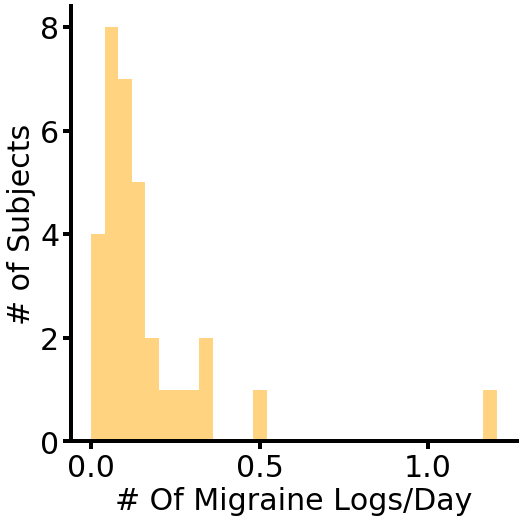

In [5]:
_, ax = plt.subplots(figsize=(8, 8))
ax.hist(
    pain_count_df['mig_pain_freq'],
    alpha=.5,
    color=palette['mbrep_pain_level_1'],
    bins=30
);
fmt.despine_thicken_axes(
    ax=ax,
    lw=4,
    fontsize=30,
    rotate_x=0,
)
ax.set_xlabel('# Of Migraine Logs/Day')
ax.set_ylabel('# of Subjects');

## Q2 How are migraine locations distributed? 

In [145]:
def melt_pain_loc(col_base, data, keep_cols: list = []):
    loc_cols = [col for col in data.columns if re.match(b+r'_\d+$', col)]
    pain_df = longitudinal_data[['Date', 'subject_id'] + loc_cols + keep_cols]

    pain_df = pain_df.melt(
        id_vars=['Date', 'subject_id'] + keep_cols,
        value_vars=loc_cols,
        var_name='n_logs',
        value_name=col_base
    )
    pain_df[col_base] = pain_df[col_base].str.split(',')
    pain_df = pain_df.explode(column=col_base)
    pain_df[col_base] = pain_df[col_base].astype(float)
    str_map = map_data.map_value_from_data_dict(
        pain_df,
        col_base
    )
    pain_df[col_base + '_str'] = map_data.map_value_from_data_dict(
        pain_df,
        col_base
    )
    return pain_df

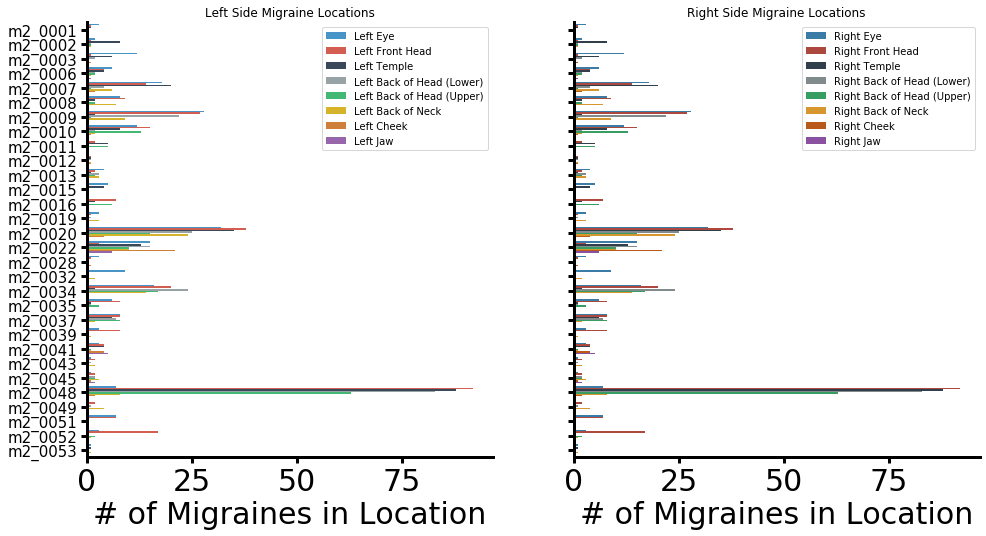

In [138]:

importlib.reload(map_data)
fig, axes = plt.subplots(ncols=2, figsize=(16, 8), sharey=True)
palette = load_palette()
col_bases = ['mbrep_pain_pos_left', 'mbrep_pain_pos_right']
i=0

    
for col_base in col_bases:
    pain_df = melt_pain_loc(col_base, longitudinal_data)

    ax = axes.flatten()[i]
    count = pd.DataFrame(
        pain_df.groupby(['subject_id', col_base + '_str']).count()
    ).reset_index()


    sns.barplot(
        x=col_base,
        y='subject_id',
        data=count,
        hue=col_base + '_str',
        ax=ax,
        palette=palette[col_base + '_str']
    )

    fmt.despine_thicken_axes(
        ax=ax,
        lw=3,
        fontsize=30,
        rotate_x=0,
        y_tick_fontsize=15
    )
    ax.legend(title='', loc='upper right')
    ax.set_title(col_base.split('_')[-1].title() + ' Side Migraine Locations')
    ax.set_xlabel('# of Migraines in Location')
    ax.set_ylabel('')
    i+=1

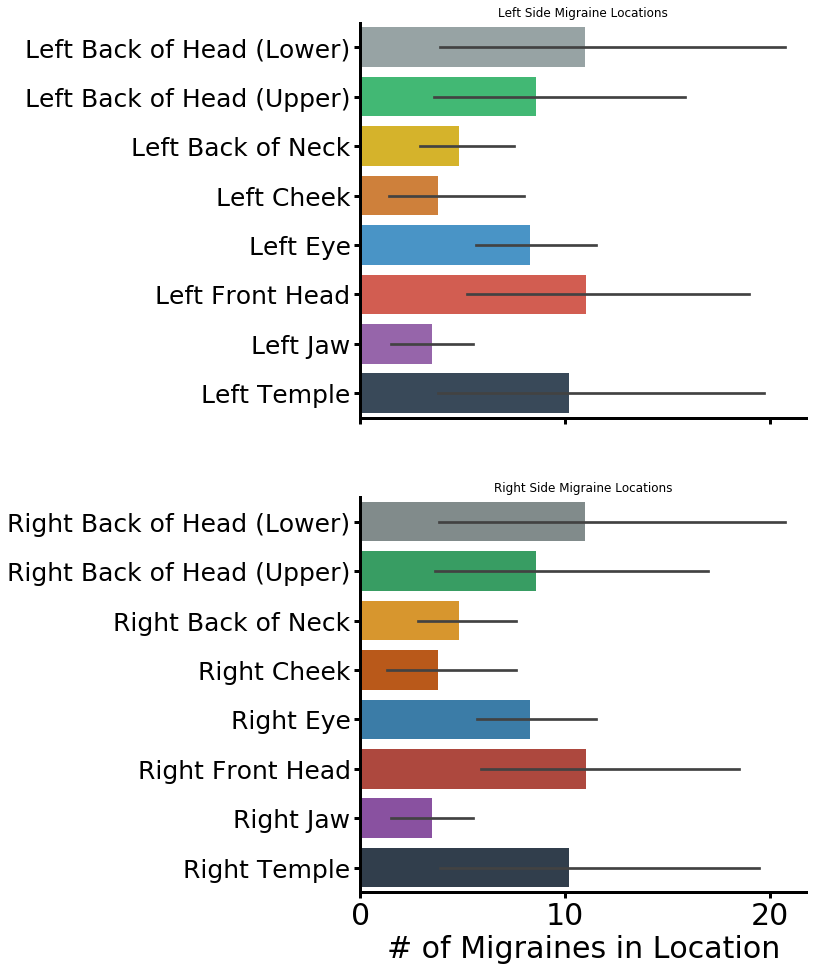

In [140]:
fig, axes = plt.subplots(nrows=2, figsize=(8, 16), sharex=True)
col_bases = ['mbrep_pain_pos_left', 'mbrep_pain_pos_right']
palette = load_palette()
loc_order = {}

i=0
for col_base in col_bases:
    pain_df = melt_pain_loc(col_base, longitudinal_data, ['catmh_mdd_diagnosis'])
    count = pd.DataFrame(
        pain_df.groupby([col_base + '_str', 'subject_id'])['Date'].count()
    ).reset_index()
    loc_order[col_base+'_str'] = list(count[col_base + '_str'].unique())
    ax = axes.flatten()[i]
    sns.barplot(
        y=col_base + '_str',
        x='Date',
        data=count,
        ax=ax,
        palette=palette[col_base + '_str']
    )

    fmt.despine_thicken_axes(
        ax=ax,
        lw=3,
        fontsize=30,
        rotate_x=0,
        y_tick_fontsize=25
    )
    ax.set_title(col_base.split('_')[-1].title() + ' Side Migraine Locations')
    ax.set_xlabel('')
    if i:
        ax.set_xlabel('# of Migraines in Location')
    ax.set_ylabel('')
    i+=1

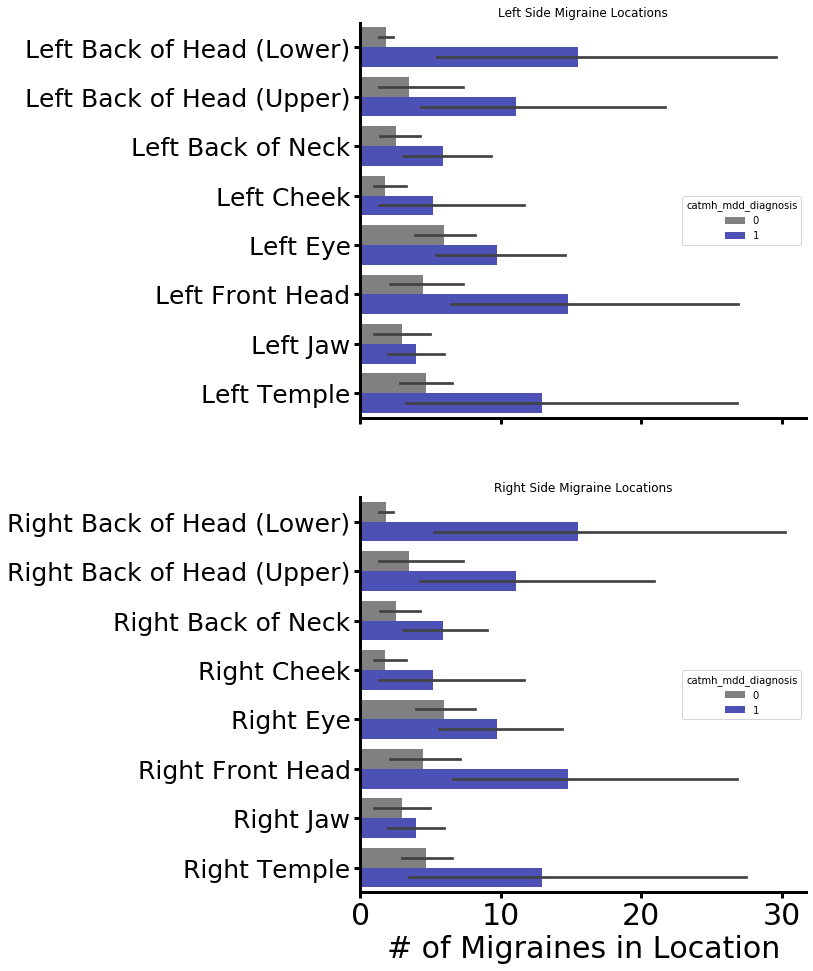

In [147]:
fig, axes = plt.subplots(nrows=2, figsize=(8, 16), sharex=True)
col_bases = ['mbrep_pain_pos_left', 'mbrep_pain_pos_right']
palette = load_palette()
loc_order = {}

i=0
for col_base in col_bases:
    pain_df = melt_pain_loc(col_base, longitudinal_data, ['catmh_mdd_diagnosis'])
    count = pd.DataFrame(
        pain_df.groupby([col_base + '_str', 'subject_id', 'catmh_mdd_diagnosis'])['Date'].count()
    ).reset_index()
    loc_order[col_base+'_str'] = list(count[col_base + '_str'].unique())
    ax = axes.flatten()[i]
    sns.barplot(
        y=col_base + '_str',
        x='Date',
        hue='catmh_mdd_diagnosis',
        dodge=True,
        data=count,
        ax=ax,
        palette=palette['catmh_mdd_diagnosis']
    )

    fmt.despine_thicken_axes(
        ax=ax,
        lw=3,
        fontsize=30,
        rotate_x=0,
        y_tick_fontsize=25
    )
    ax.set_title(col_base.split('_')[-1].title() + ' Side Migraine Locations')
    ax.set_xlabel('')
    if i:
        ax.set_xlabel('# of Migraines in Location')
    ax.set_ylabel('')
    i+=1

## Q2.1 Do Migraine Locations Co-Occur in left/right side?

In [131]:
level_col_base = 'mbrep_pain_level'

level_cols = [col for col in longitudinal_data.columns if level_col_base in col]
level_df = longitudinal_data[['Date', 'subject_id', 'catmh_mdd_diagnosis'] + level_cols]

level_df = level_df.melt(
    id_vars=['Date', 'subject_id', 'catmh_mdd_diagnosis'],
    value_vars=level_cols,
    var_name='n_logs',
    value_name=level_col_base
)

level_df['n_logs'] = level_df['n_logs'].str.split('_').str[-1].astype(int)
merged_df = level_df.copy()
for loc_col_base in col_bases:
    print(loc_col_base)
    loc_cols = [col for col in longitudinal_data.columns if loc_col_base in col]
    loc_df = melt_pain_loc(loc_col_base, longitudinal_data)
    loc_df['n_logs'] = loc_df['n_logs'].str.split('_').str[-1].astype(int)
    merged_df = merged_df.merge(
        loc_df,
        how='outer',
        #validate='1:1' # Commented out since with more than 1 location per log, may be any comb of 1:m, m:m, or m:1
    )
merged_df.head()

mbrep_pain_pos_left
mbrep_pain_pos_right


,Date,subject_id,catmh_mdd_diagnosis,n_logs,mbrep_pain_level,mbrep_pain_pos_left,mbrep_pain_pos_left_str,mbrep_pain_pos_right,mbrep_pain_pos_right_str
0,2018-10-24,m2_0049,1,1,NaN,NaN,NaN,NaN,NaN
1,2018-10-25,m2_0049,1,1,NaN,NaN,NaN,NaN,NaN
2,2018-10-26,m2_0049,1,1,NaN,NaN,NaN,NaN,NaN
3,2018-10-27,m2_0049,1,1,NaN,NaN,NaN,NaN,NaN
4,2018-10-28,m2_0049,1,1,NaN,NaN,NaN,NaN,NaN


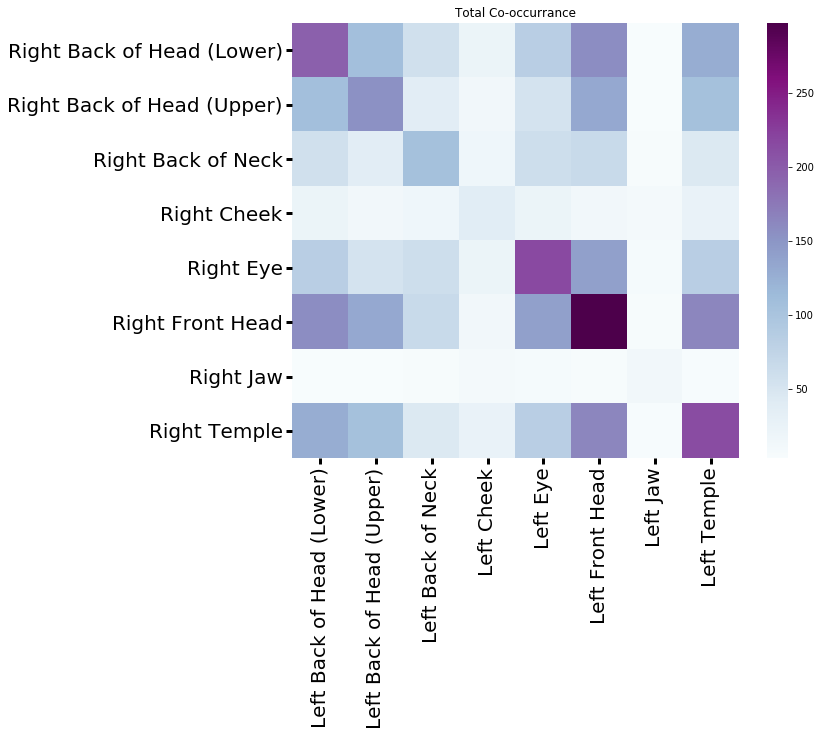

In [132]:
count_df = pd.DataFrame(
    merged_df.groupby(['mbrep_pain_pos_left_str', 'mbrep_pain_pos_right_str'])['Date'].count()
).reset_index()
piv_loc = count_df.pivot_table(
    columns='mbrep_pain_pos_left_str',
    index='mbrep_pain_pos_right_str',
    values='Date',
    fill_value=0,
)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(piv_loc, cmap='BuPu', ax=ax)
ax.set_title('Total Co-occurrance')

ax.tick_params(axis='both', which='major', width=3, length=6, labelsize=20)
ax.set_ylabel('')
ax.set_xlabel('');

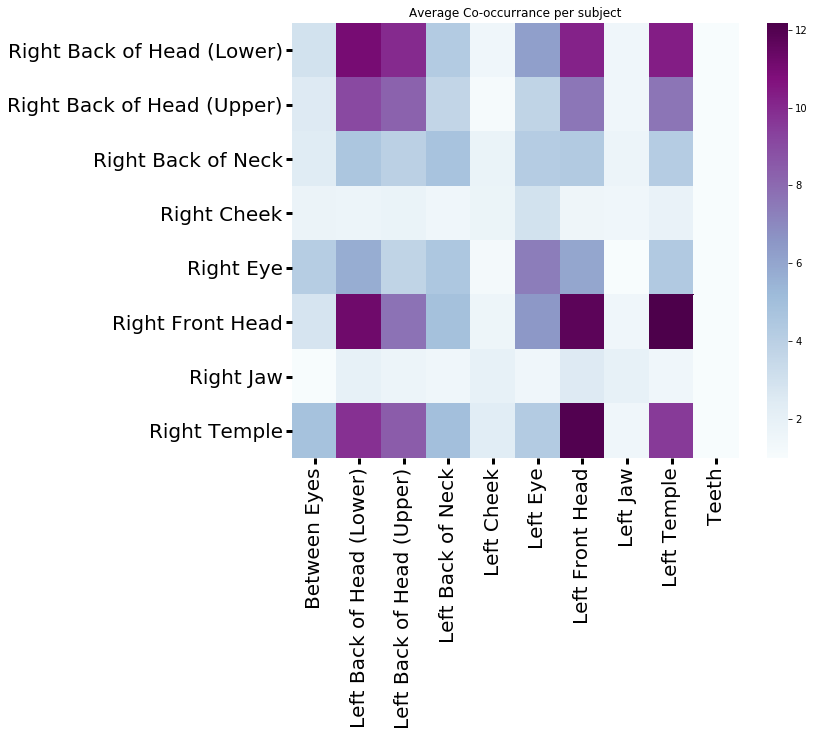

In [70]:
count_df = pd.DataFrame(
    merged_df.groupby(['subject_id', 'mbrep_pain_pos_left_str', 'mbrep_pain_pos_right_str'])['Date'].count()
).reset_index()
piv_loc = count_df.pivot_table(
    columns='mbrep_pain_pos_left_str',
    index='mbrep_pain_pos_right_str',
    values='Date',
    fill_value=0,
    aggfunc=np.mean,
)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(piv_loc, cmap='BuPu', ax=ax)
ax.tick_params(axis='both', which='major', width=3, length=6, labelsize=20)
ax.set_title('Average Co-occurrance per subject')
ax.set_ylabel('')
ax.set_xlabel('');

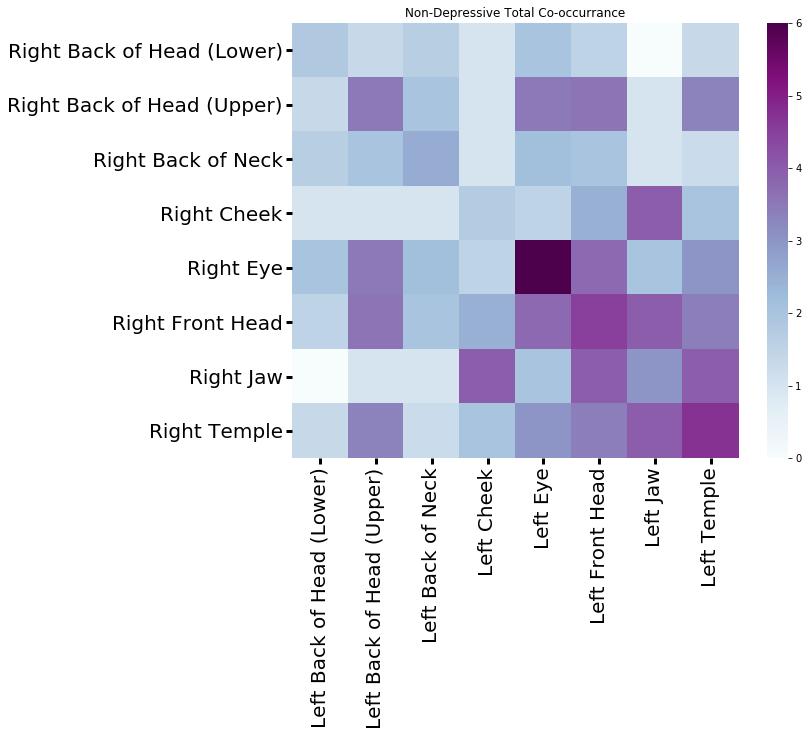

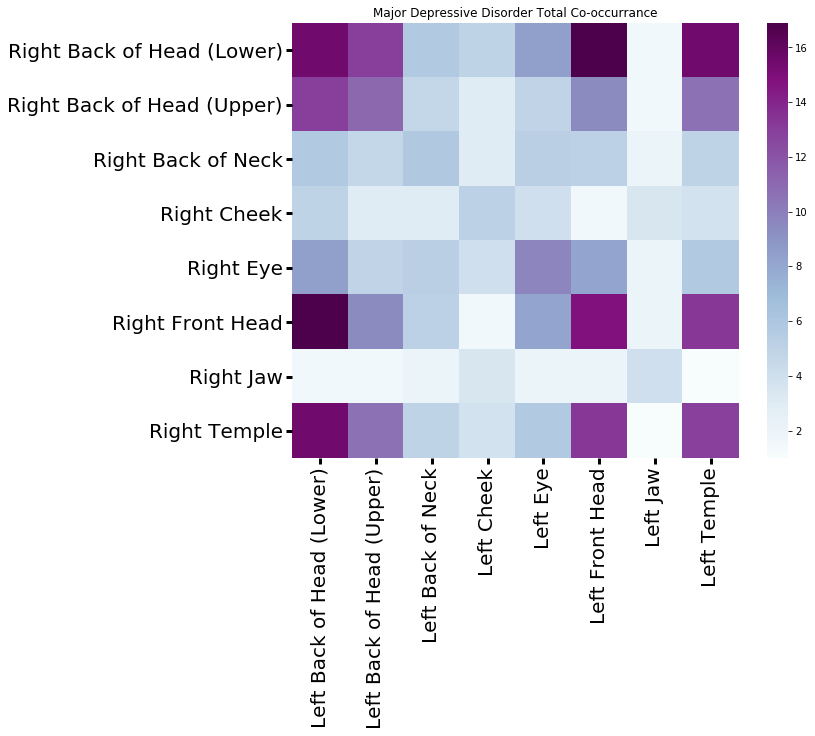

In [136]:
for diagnosis, mdd_df in merged_df.groupby('catmh_mdd_diagnosis'):
    count_df = pd.DataFrame(
        mdd_df.groupby(['mbrep_pain_pos_left_str', 'mbrep_pain_pos_right_str', 'subject_id'])['Date'].count()
    ).reset_index()
    piv_loc = count_df.pivot_table(
        columns='mbrep_pain_pos_left_str',
        index='mbrep_pain_pos_right_str',
        values='Date',
        fill_value=0,
    )
    fig, ax = plt.subplots(figsize=(10,8))
    sns.heatmap(piv_loc, cmap='BuPu', ax=ax)
    diag_map = {
        0: 'Non-Depressive',
        1: 'Major Depressive Disorder'
    }
    ax.set_title(diag_map[diagnosis] + ' Total Co-occurrance')

    ax.tick_params(axis='both', which='major', width=3, length=6, labelsize=20)
    ax.set_ylabel('')
    ax.set_xlabel('');

## Q2.2 Is migraine location associated with pain severity?

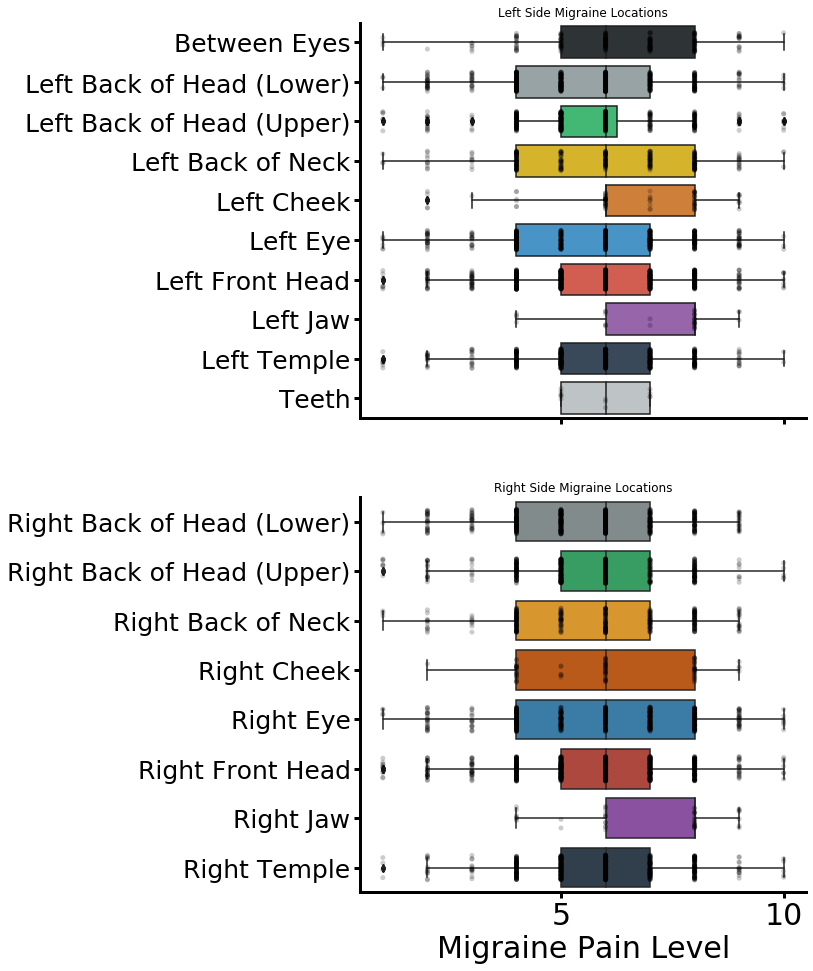

In [74]:
fig, axes = plt.subplots(nrows=2, figsize=(8,16), sharex=True)
i=0
palette = load_palette()
for loc_col_base in col_bases:
    ax = axes[i]
    sns.boxplot(
        y=loc_col_base + '_str',
        x=level_col_base,
        palette=palette[loc_col_base + '_str'],
        order=loc_order[loc_col_base + '_str'],
        ax=ax,
        data=merged_df,
    )
    sns.stripplot(
        y=loc_col_base + '_str',
        x=level_col_base,
        order=loc_order[loc_col_base + '_str'],
        color='black',
        ax=ax,
        data=merged_df,
        alpha=0.2,
        jitter=.25,
    )
    fmt.despine_thicken_axes(
        ax=ax,
        lw=3,
        fontsize=30,
        rotate_x=0,
        y_tick_fontsize=25
    )
    ax.set_title(loc_col_base.split('_')[-1].title() + ' Side Migraine Locations')
    ax.set_xlabel('')
    ax.set_ylabel('')
    #ax.legend().remove()
    i+=1
ax.set_xlabel('Migraine Pain Level');

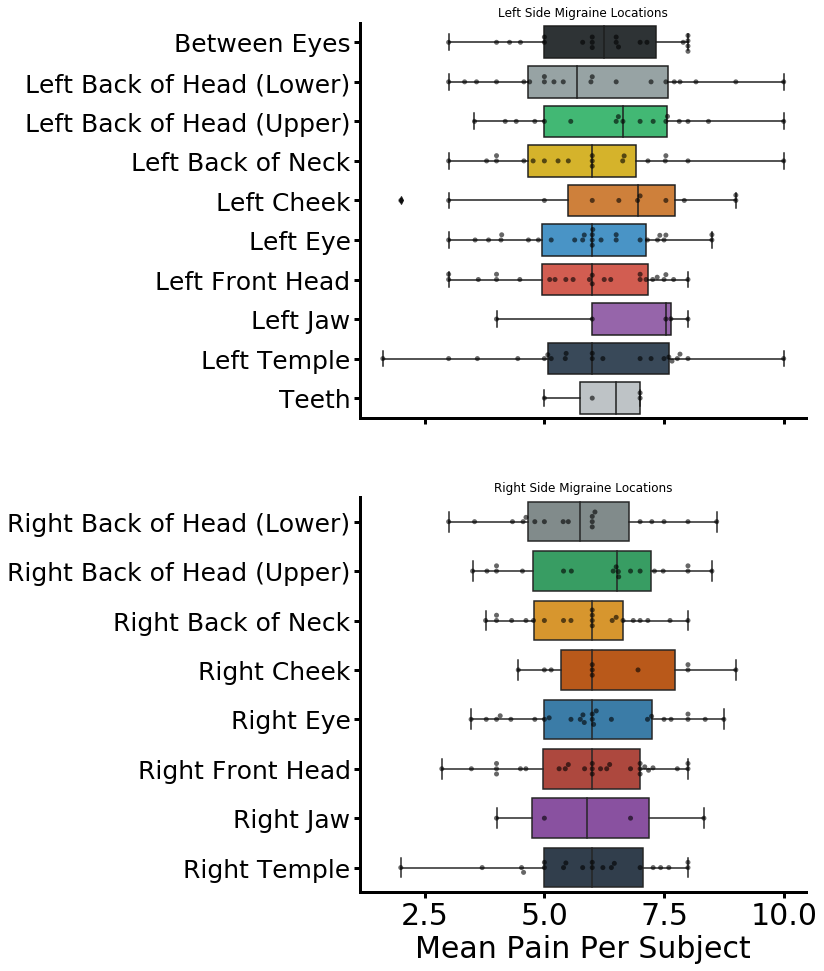

In [80]:
fig, axes = plt.subplots(nrows=2, figsize=(8,16), sharex=True)
i=0
palette = load_palette()
for loc_col_base in col_bases:
    ax = axes[i]
    per_subject = pd.DataFrame(merged_df.groupby(
        ['subject_id', loc_col_base + '_str']
    )[level_col_base].mean()).reset_index()
    sns.boxplot(
        y=loc_col_base + '_str',
        x=level_col_base,
        palette=palette[loc_col_base + '_str'],
        order=loc_order[loc_col_base + '_str'],
        ax=ax,
        data=per_subject,
    )
    sns.swarmplot(
        y=loc_col_base + '_str',
        x=level_col_base,
        order=loc_order[loc_col_base + '_str'],
        color='black',
        ax=ax,
        data=per_subject,
        alpha=0.6,
    )
    fmt.despine_thicken_axes(
        ax=ax,
        lw=3,
        fontsize=30,
        rotate_x=0,
        y_tick_fontsize=25
    )
    ax.set_title(loc_col_base.split('_')[-1].title() + ' Side Migraine Locations')
    ax.set_xlabel('')
    ax.set_ylabel('')
    i+=1
ax.set_xlabel('Mean Pain Per Subject');

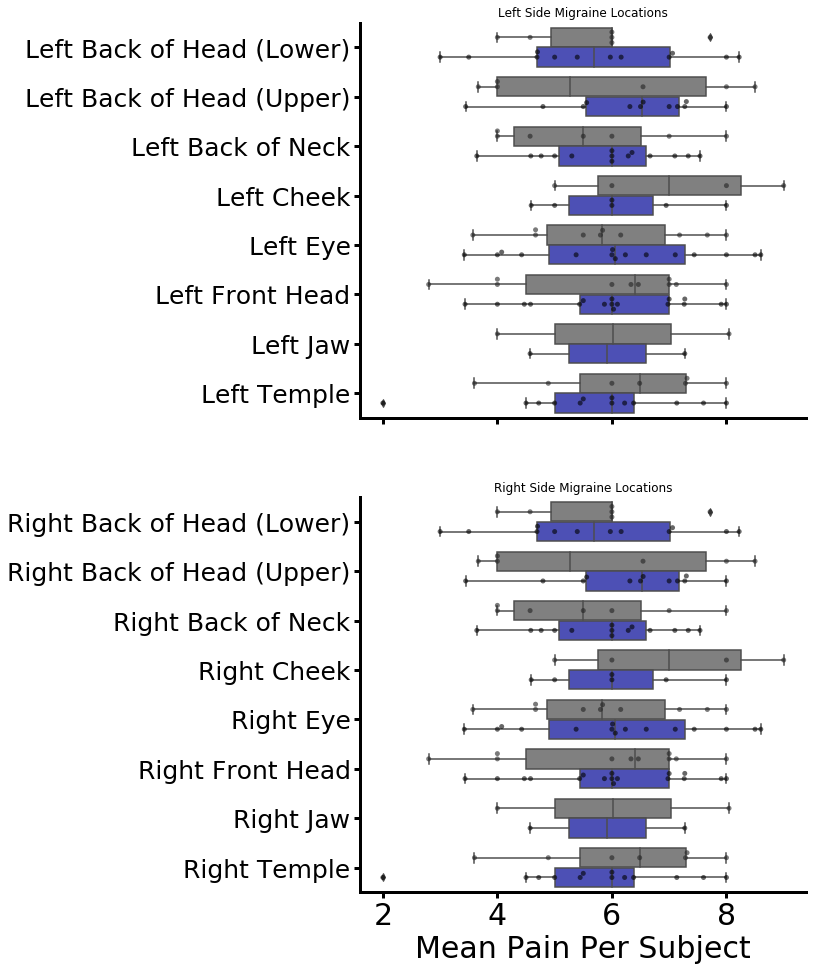

In [149]:
fig, axes = plt.subplots(nrows=2, figsize=(8,16), sharex=True)
i=0
palette = load_palette()
for loc_col_base in col_bases:
    ax = axes[i]
    per_subject = pd.DataFrame(merged_df.groupby(
        ['subject_id', loc_col_base + '_str', 'catmh_mdd_diagnosis']
    )[level_col_base].mean()).reset_index()
    sns.boxplot(
        y=loc_col_base + '_str',
        x=level_col_base,
        hue='catmh_mdd_diagnosis',
        dodge=True,
        palette=palette['catmh_mdd_diagnosis'],
        order=loc_order[loc_col_base + '_str'],
        ax=ax,
        data=per_subject,
    )
    sns.swarmplot(
        y=loc_col_base + '_str',
        x=level_col_base,
        order=loc_order[loc_col_base + '_str'],
        hue='catmh_mdd_diagnosis',
        dodge=True,
        color='black',
        ax=ax,
        data=per_subject,
        alpha=0.6,
    )
    fmt.despine_thicken_axes(
        ax=ax,
        lw=3,
        fontsize=30,
        rotate_x=0,
        y_tick_fontsize=25
    )
    ax.set_title(loc_col_base.split('_')[-1].title() + ' Side Migraine Locations')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.legend().remove()
    i+=1
ax.set_xlabel('Mean Pain Per Subject');


## Q3: Do 2 day min max pressure changes predict migraine frequency?
- Not sure how to assess frequency, went with duration instead

In [118]:
def n_day_min_max_barom(data, n: int, at_time: bool, diff_of_avg: bool):
    min_col = 'min_barom_pressure'
    max_col = 'max_barom_pressure'
    avg_col = 'average_barom_pressure'
    diff_col = str(n) + '_pressure_diff'
    
    sort_d = data.sort_values(by=['subject_id', 'Date']).reset_index()
    sort_d[diff_col] = np.nan
    diff_dfs = []
    for g, g_df in sort_d.groupby('subject_id'):
        diffs = []
        mbrep_indices = np.where(~g_df.mbrep_pain_level_1.isna())[0]
        if at_time:
             leading_days = [[ind-n, ind] for ind in mbrep_indices]
        else:
            leading_days = [np.arange(ind-n,ind+1,1) for ind in mbrep_indices]
            
        for days in leading_days:
            if diff_of_avg:
                min_val = g_df.iloc[days][avg_col].min()
                max_val = g_df.iloc[days][avg_col].max()
            else:
                min_val = g_df.iloc[days][min_col].min()
                max_val = g_df.iloc[days][max_col].max()
            diff = max_val - min_val
            diffs.append(diff)
        d = g_df.iloc[mbrep_indices][['subject_id', 'Date', diff_col]]
        d[diff_col] = diffs
        diff_dfs.append(d)
            
    diff_df = pd.concat(diff_dfs, sort=False)
    return diff_col, data.merge(diff_df, how='left', validate='1:1')

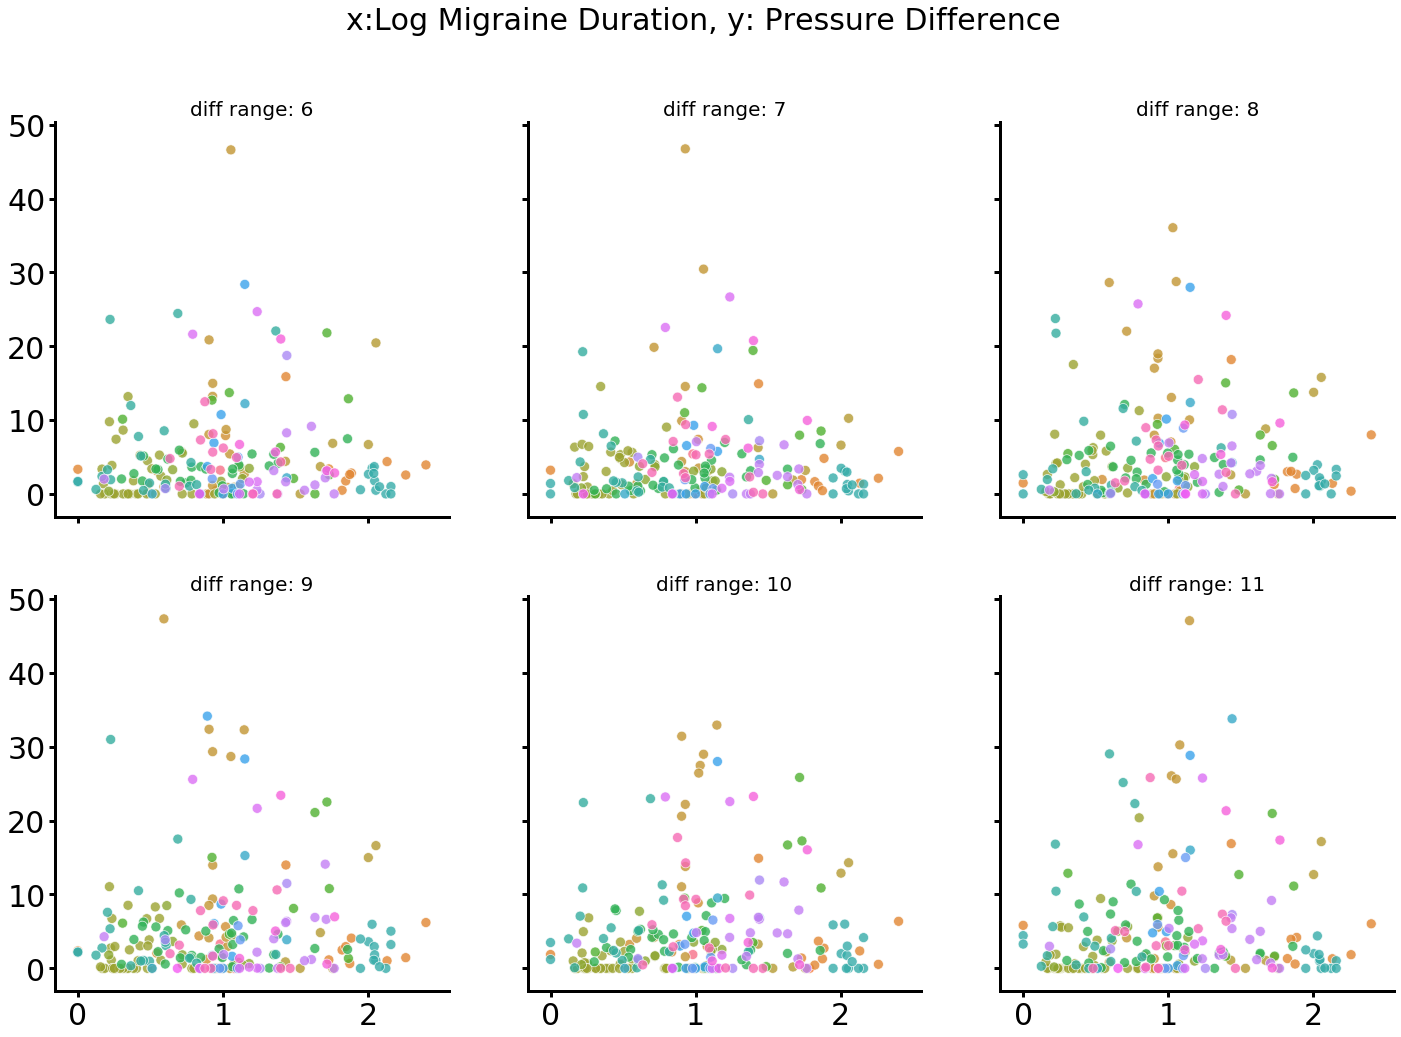

In [120]:

fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(24,16), sharey=True, sharex=True)
for i in range(6):
    ax = axes.flatten()[i]
    j = i + 0
    diff_col, with_diff = n_day_min_max_barom(
        longitudinal_data,
        j,
        at_time=True,
        diff_of_avg=True,
    )
    duration_cols = [col for col in with_diff.columns if 'mbrep_duration_' in col]
    with_diff['log_duration_sum'] = np.log10(1 + with_diff[duration_cols].sum(axis=1))
    sns.scatterplot(
        x='log_duration_sum',
        y=diff_col,
        data=with_diff,
        ax=ax,
        s=100,
        alpha=0.8,
        hue='subject_id'
    )
    fmt.despine_thicken_axes(
        ax=ax,
        lw=3,
        fontsize=30,
        rotate_x=0,
    )
    ax.set_title('diff range: ' + str(j), fontsize=20)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.legend().remove();
plt.suptitle('x:Log Migraine Duration, y: Pressure Difference', fontsize=30);

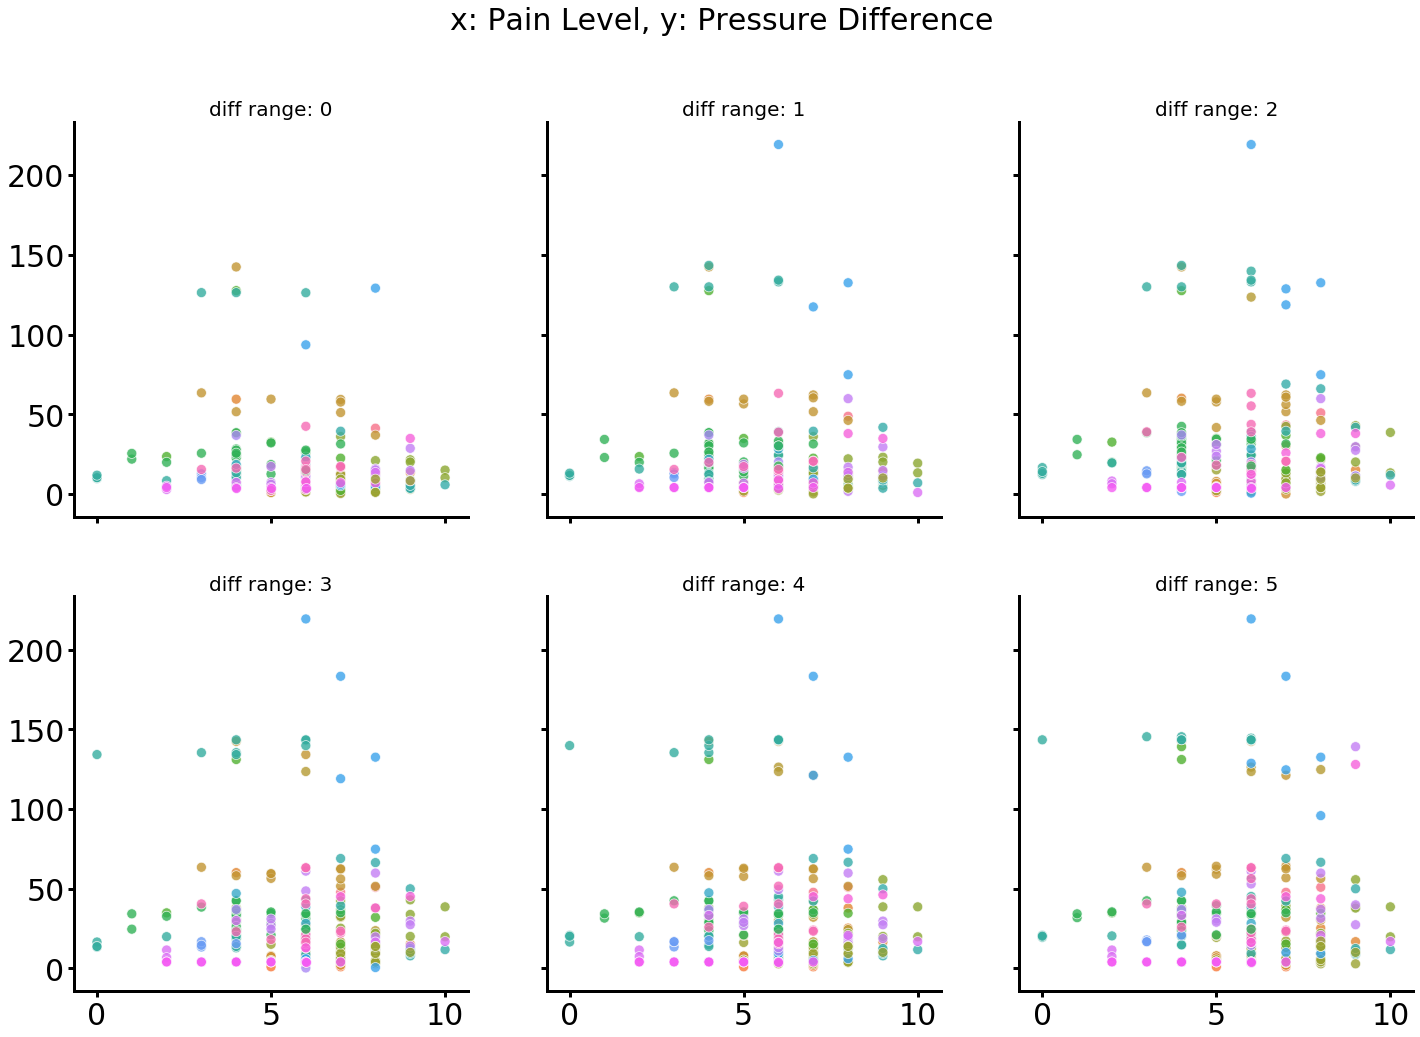

In [83]:

fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(24,16), sharey=True, sharex=True)
for i in range(6):
    ax = axes.flatten()[i]
    j = i + 0
    diff_col, with_diff = n_day_min_max_barom(longitudinal_data, j, False)
    pain_cols = [col for col in with_diff.columns if 'mbrep_pain_level_' in col]
    for pc in pain_cols:
        sns.scatterplot(
            x=pc,
            y=diff_col,
            data=with_diff,
            ax=ax,
            s=100,
            alpha=0.8,
            hue='subject_id'
        )
    fmt.despine_thicken_axes(
        ax=ax,
        lw=3,
        fontsize=30,
        rotate_x=0,
    )
    ax.set_title('diff range: ' + str(j), fontsize=20)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.legend().remove();
plt.suptitle('x: Pain Level, y: Pressure Difference', fontsize=30);

## Q3.1: Does controlling for bilateral migraine only show a prediction?

### Result:
- Preliminarily does not seem to be the case 

In [121]:
import progressbar as pb
diff_col, with_diff = n_day_min_max_barom(longitudinal_data, 3, True, True)

# Melt: migraine_duration, mbrep_pain_pos_left, mbrep_pain_pos_right
bases = ['mbrep_duration', 'mbrep_pain_level', 'mbrep_pain_pos_left', 'mbrep_pain_pos_right']
melted_df = with_diff.copy()
for b in bases:
    cols = [col for col in with_diff.columns if re.match(b+r'_\d+$', col)]
    print('\nMelt Cols:', cols)
    not_na_df = with_diff[['Date', 'subject_id'] + cols].dropna(subset=[b+'_1'])
    print('Len Change:', not_na_df.shape[0] - with_diff.shape[0], 'Length After: ', not_na_df.shape[0])
    melt_df = not_na_df.melt(
        id_vars=['Date', 'subject_id'],
        value_vars=cols,
        var_name=b+'_n',
        value_name=b
    )
    melt_df['n'] = melt_df[b+'_n'].str.split('_').str[-1].astype(int)
    melted_df = melted_df.merge(
        melt_df[['Date', 'subject_id', 'n', b]],
        how='outer',
    )
    if 'pos' in b:
        melt_df[b] = melt_df[b].str.split(',')
        melted_df = melted_df.explode(column=b)

    print('Melt Len: ', melt_df.shape[0])


Melt Cols: ['mbrep_duration_1', 'mbrep_duration_2', 'mbrep_duration_3', 'mbrep_duration_4', 'mbrep_duration_5', 'mbrep_duration_6']
Len Change: -2679 Length After:  457
Melt Len:  2742

Melt Cols: ['mbrep_pain_level_1', 'mbrep_pain_level_2', 'mbrep_pain_level_3', 'mbrep_pain_level_4', 'mbrep_pain_level_5', 'mbrep_pain_level_6']
Len Change: -2675 Length After:  461
Melt Len:  2766

Melt Cols: ['mbrep_pain_pos_left_1', 'mbrep_pain_pos_left_2', 'mbrep_pain_pos_left_3', 'mbrep_pain_pos_left_4', 'mbrep_pain_pos_left_5', 'mbrep_pain_pos_left_6']
Len Change: -2750 Length After:  386
Melt Len:  2316

Melt Cols: ['mbrep_pain_pos_right_1', 'mbrep_pain_pos_right_2', 'mbrep_pain_pos_right_3', 'mbrep_pain_pos_right_4', 'mbrep_pain_pos_right_5', 'mbrep_pain_pos_right_6']
Len Change: -2735 Length After:  401
Melt Len:  2406


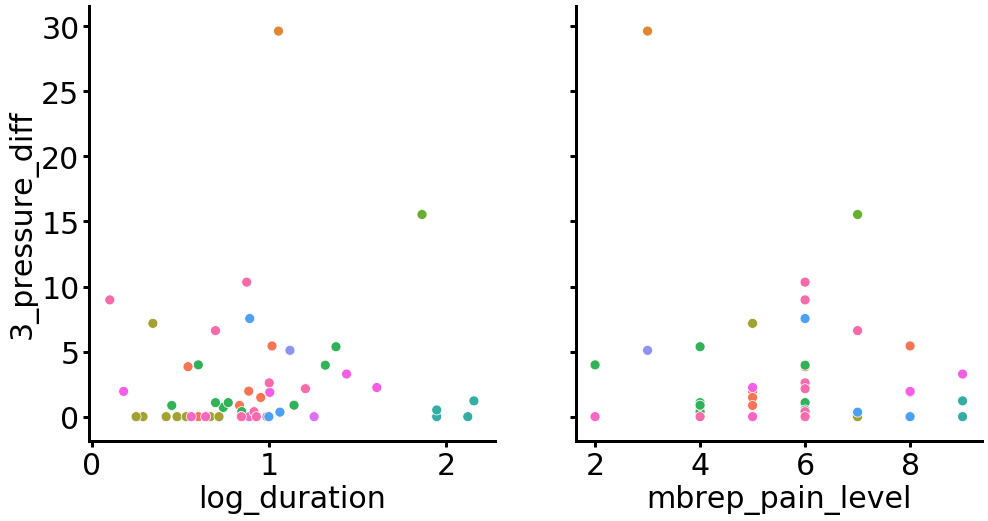

In [124]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 8), sharey=True)

bilat = melted_df[
    (melted_df[bases[2]] == melted_df[bases[3]]) |
    (melted_df[bases[2]].isin([6,7]))
].copy()
bilat['log_duration'] = np.log10(1+bilat['mbrep_duration'])
cols = ['log_duration', 'mbrep_pain_level']
for i in range(2):
    ax = axes.flatten()[i]
    sns.scatterplot(
        y=diff_col,
        x=cols[i],
        data=bilat,
        hue='subject_id',
        ax=ax,
        s=100,
    )
    ax.legend().remove()
    fmt.despine_thicken_axes(
        ax=ax,
        lw=3,
        fontsize=30,
        rotate_x=0,
    );

## Q4 Does this population exprience Auras? Population level ~25% of people with migraines get aura's.

### Result
Yes, at a very high level, 94% (31/33) of subjects at some point experienced/logged a form of aura

In [114]:
aur_cols = [col for col in longitudinal_data.columns if re.match(r'mbrep_auras_\d+$', col)]
longitudinal_data['sum_aura'] = longitudinal_data[aur_cols].notna().sum(axis=1)
longitudinal_data['has_aura'] = longitudinal_data['sum_aura'].astype(bool)
sub_aura = pd.DataFrame(longitudinal_data.groupby('subject_id').sum_aura.sum()).reset_index()
sub_aura['has_aura'] = sub_aura['sum_aura'].astype(bool)
pd.DataFrame(sub_aura.groupby('has_aura').subject_id.nunique())

,subject_id
has_aura,
False,2
True,31
